# ESMA 2025 BSE Project

In [ ]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import warnings
import os
import scipy.stats as stats
from esmaplotly import esmaplotly
import plotly.graph_objects as go
import pyspark.sql.functions as f
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from pyspark.sql.functions import udf, col
from pyspark.sql.types import TimestampType
from pyspark.sql.window import Window
from skforecast.recursive import ForecasterRecursive
from sklearn.tree import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import esmaplotly as epy

warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"


In [3]:
spark = SparkSession.builder.appName("ExcelToSpark").getOrCreate()
file1_pd = pd.read_csv("fl1.csv")
file2_pd = pd.read_csv("fl2.csv")

file1_spark = spark.createDataFrame(file1_pd)
file2_spark = spark.createDataFrame(file2_pd)

df_joined = file1_spark.join(file2_spark, on='KEY', how='left')

In [4]:
df_joined.printSchema()


root
 |-- KEY: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- TITLE_COMPL: double (nullable = true)
 |-- PROSP3_MEASURE: string (nullable = true)
 |-- FREQ: string (nullable = true)
 |-- S_NCA: string (nullable = true)
 |-- PROSP3_SECURITIES_TYPE: string (nullable = true)
 |-- MTR: string (nullable = true)
 |-- CURR_ISSNC: string (nullable = true)
 |-- PROSP3_OFFER_TYPE: string (nullable = true)
 |-- PROSP3_DOCUMENT_TYPE: string (nullable = true)
 |-- SEC_TYPE_CFI: string (nullable = true)
 |-- ISSUER_COU: string (nullable = true)
 |-- ISSUER_SECTOR: string (nullable = true)
 |-- PROSP3_PRSP_TYPE: string (nullable = true)
 |-- PROSP3_SME_CAT_TYPE: string (nullable = true)
 |-- PROSP3_PSSP: string (nullable = true)
 |-- PROSP3_VENUE: string (nullable = true)
 |-- PROSP3_LNGG: string (nullable = true)
 |-- MV: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- TIME_PERIOD: string (nullable = true)
 |-- PK: double (nullable = true)
 |-- OBS_VALUE: doubl

In [5]:
df_joined.show(10)

25/06/16 18:50:00 WARN TaskSetManager: Stage 6 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+-----

## 1. Thresholds

In [ ]:
def add_outlier_thresholds(
    data,
    numbercol,
    groupbycols=None,
    showstats=False,
    use_logs=False,
    outlier_mode= 4  # options: '3sd', '4sd', 'both'
):
    """
    Flags outliers in the specified numeric column based on group-level
    median ± 3 or 4 standard deviations.

    Parameters:
    - data: Spark DataFrame
    - numbercol: str, column to evaluate
    - groupbycols: list of str, columns to group by
    - showstats: bool, print number of outliers
    - use_logs: bool, apply log to the column before comparison
    - outlier_mode: str, one of ['3sd', '4sd', 'both']
    """
    if groupbycols is None:
        groupbycols = []

    col3sd = f"{numbercol}_3sd"
    col4sd = f"{numbercol}_4sd"

    # Step 1: compute median + stddev per group
    stats_df = (
        data.groupBy(groupbycols)
        .agg(
            f.expr(f'percentile_approx({numbercol}, 0.5)').alias('median'),
            f.stddev(numbercol).alias('stddev')
        )
    )

    # Step 2: join stats back to original data
    if groupbycols:
        join_condition = reduce(
            lambda x, y: x & y,
            [f.col(f"data.{col}") == f.col(f"stats.{col}") for col in groupbycols]
        )
        data = data.alias("data").join(stats_df.alias("stats"), on=join_condition, how="left")

    else:
        data = (
            data.withColumn("dummykey", f.lit(1))
            .join(stats_df.withColumn("dummykey", f.lit(1)), on="dummykey", how="left")
            .drop("dummykey")
        )


    data = data.drop(*[f"stats.{col}" for col in groupbycols])
    # Step 3: prepare value for thresholding
    val = f.log(f.abs(f.col(numbercol))) if use_logs else f.col(numbercol)

    # Step 4: flag outliers
    if outlier_mode in (3, 'both'):
        data = data.withColumn(
            col3sd, (val > f.col("median") + 3 * f.col("stddev")) | (val < f.col("median") - 3 * f.col("stddev"))
        )
    if outlier_mode in (4, 'both'):
        data = data.withColumn(
            col4sd, (val > f.col("median") + 4 * f.col("stddev")) | (val < f.col("median") - 4 * f.col("stddev"))
        )

    # Step 5: assign `is_outlier`
    if outlier_mode == 3:
        data = data.withColumn("is_outlier", f.col(col3sd))
    elif outlier_mode == 4:
        data = data.withColumn("is_outlier", f.col(col4sd))
    elif outlier_mode == 'both':
        # don't overwrite is_outlier, just return both _3sd and _4sd flags
        pass
    else:
        raise ValueError("Invalid outlier_mode. Choose from '3sd', '4sd', or 'both'.")

    # Step 6: optional summary
    if showstats:
        if outlier_mode in (3, 'both'):
            print(f"[3SD OUTLIERS] {numbercol}: {data.filter(f.col(col3sd)).count()}")
        if outlier_mode in (4, 'both'):
            print(f"[4SD OUTLIERS] {numbercol}: {data.filter(f.col(col4sd)).count()}")

    # Step 7: clean up
    return data.drop('median', 'stddev')

In [ ]:
def add_outlier_thresholds_percentile(
    data,
    numbercol,
    groupbycols=None,
    showstats=False,
    use_logs=False,
    outlier_mode=4,  # options: '3sd', '4sd', 'both'
    pre_filter_percentile=None  # e.g., 0.99 to drop top 1% values before computing std
):
    """
    Flags outliers in the specified numeric column based on group-level
    median ± 3 or 4 standard deviations.

    Parameters:
    - data: Spark DataFrame
    - numbercol: str, column to evaluate
    - groupbycols: list of str, columns to group by
    - showstats: bool, print number of outliers
    - use_logs: bool, apply log to the column before comparison
    - outlier_mode: str, one of ['3sd', '4sd', 'both']
    - pre_filter_percentile: float between 0 and 1 to drop top values before computing std
    """
    if groupbycols is None:
        groupbycols = []

    col3sd = f"{numbercol}_3sd"
    col4sd = f"{numbercol}_4sd"
    outlier_col = f"{numbercol}_is_outlier"  # 🆕 dynamic column name

    # Step 0: Optional pre-filtering by percentile
    if pre_filter_percentile is not None:
        perc_expr = f"percentile_approx({numbercol}, {pre_filter_percentile})"
        perc_df = data.groupBy(groupbycols).agg(f.expr(perc_expr).alias("cutoff"))

        if groupbycols:
            join_condition = reduce(
                lambda x, y: x & y,
                [f.col(f"data.{col}") == f.col(f"cut.{col}") for col in groupbycols]
            )
            data = (
                data.alias("data")
                .join(perc_df.alias("cut"), on=join_condition, how="left")
                .filter(f.col(numbercol) <= f.col("cut.cutoff"))
                .drop("cut.cutoff")
            )
        else:
            cutoff = data.selectExpr(perc_expr).collect()[0][0]
            data = data.filter(f.col(numbercol) <= cutoff)

    # Step 1: compute median + stddev per group
    stats_df = (
        data.groupBy(groupbycols)
        .agg(
            f.expr(f'percentile_approx({numbercol}, 0.5)').alias('median'),
            f.stddev(numbercol).alias('stddev')
        )
    )

    # Step 2: join stats back to original data
    if groupbycols:
        join_condition = reduce(
            lambda x, y: x & y,
            [f.col(f"data.{col}") == f.col(f"stats.{col}") for col in groupbycols]
        )
        data = data.alias("data").join(stats_df.alias("stats"), on=join_condition, how="left")
    else:
        data = (
            data.withColumn("dummykey", f.lit(1))
            .join(stats_df.withColumn("dummykey", f.lit(1)), on="dummykey", how="left")
            .drop("dummykey")
        )

    data = data.drop(*[f"stats.{col}" for col in groupbycols])

    # Step 3: prepare value for thresholding
    val = f.log(f.abs(f.col(numbercol))) if use_logs else f.col(numbercol)

    # Step 4: flag outliers
    if outlier_mode in (3, 'both'):
        data = data.withColumn(
            col3sd, (val > f.col("median") + 3 * f.col("stddev")) | (val < f.col("median") - 3 * f.col("stddev"))
        )
    if outlier_mode in (4, 'both'):
        data = data.withColumn(
            col4sd, (val > f.col("median") + 4 * f.col("stddev")) | (val < f.col("median") - 4 * f.col("stddev"))
        )

    # Step 5: assign dynamic outlier flag
    if outlier_mode == 3:
        data = data.withColumn(outlier_col, f.col(col3sd))
    elif outlier_mode == 4:
        data = data.withColumn(outlier_col, f.col(col4sd))
    elif outlier_mode == 'both':
        # keep both flags but do not create final flag
        pass
    else:
        raise ValueError("Invalid outlier_mode. Choose from '3sd', '4sd', or 'both'.")

    # Step 6: optional summary
    if showstats:
        if outlier_mode in (3, 'both'):
            print(f"[3SD OUTLIERS] {numbercol}: {data.filter(f.col(col3sd)).count()}")
        if outlier_mode in (4, 'both'):
            print(f"[4SD OUTLIERS] {numbercol}: {data.filter(f.col(col4sd)).count()}")

    # Step 7: clean up
    return data.drop('median', 'stddev')

## 2. Advanced


In [ ]:
def spot(
    spark_df,
    mode='thresholds',
    numbercol='OBS_VALUE',
    groupbycols=None,
    showstats=False,
    use_logs=False,
    min_filter=None,
    min_date=None,
    feature_cols=None,
    datecol='parsed_date',
    return_mode = 'all',
    nr_sd = 4
):
    if groupbycols is None:
        groupbycols = []

#### and what do u do if group by cols is not none?? i probably need smth like
# if groupbycols: join condition = reduce( like the last function.


    if min_date:
        spark_df = spark_df.filter(f.col(datecol) >= f.lit(min_date))

    if min_filter:
        spark_df = spark_df.filter(f.col(numbercol) >= min_filter)



    if mode == 'random_forest_regressor':
        df_pd = spark_df.toPandas()
        # 3) Figure out features
        if feature_cols is None:
            numeric = df_pd.select_dtypes(include=['float','int']).columns.tolist()
            feature_cols = [c for c in numeric if c != numbercol]

        # Helper to train & flag per group
        def process_group(grp):
            if grp.shape[0] < 10:
                grp['is_outlier'] = False
                return grp

            X = grp[feature_cols]
            y = grp[numbercol]
            model = RandomForestRegressor(n_estimators=50, random_state=42)
            model.fit(X, y)

            grp['pred_rfr']      = model.predict(X)
            grp['residual_rfr']  = grp[numbercol] - grp['pred_rfr']
            sd = grp['residual_rfr'].std()
            thresh = int(nr_sd) * sd

            grp['is_outlier'] = grp['residual_rfr'].abs() > thresh
            return grp

        # 4) Apply per‐group (or once if no grouping)
        if groupbycols:
            df_out = (
                df_pd
                .groupby(groupbycols, group_keys=False)
                .apply(process_group)
                .reset_index(drop=True)
            )
        else:
            df_out = process_group(df_pd)

        if showstats:
            print(df_out['is_outlier'].value_counts())

        # 5) Anything under min_filter must be False
        if min_filter is not None:
            df_out.loc[df_out[numbercol] < min_filter, 'is_outlier'] = False

        if return_mode == 'all':
            return spark.createDataFrame(df_out)
        elif return_mode == 'outliers':
            return spark.createDataFrame(df_out[df_out['is_outlier']== True])

    elif mode == 'thresholds':
        # apply the existing threshold logic
        df_thresh = spark_df
        if min_filter is not None:
            df_thresh = df_thresh.filter(f.col(numbercol) >= min_filter)
        if min_date is not None:
            # make sure parsed_date column exists as date
            df_thresh = df_thresh.withColumn(
                datecol,
                f.to_date(f.col('TIME_PERIOD').substr(1,4).cast('int').cast('string')  # crude: extract year; adjust if you have parsed_date as a column
            )).filter(f.col(datecol) >= f.lit(min_date))

        # run your threshold outlier function, which gives back only the key cols + value + flag
        outliers_only = add_outlier_thresholds(
            data=df_thresh,
            numbercol=numbercol,
            groupbycols=groupbycols,
            showstats=showstats,
            use_logs=use_logs,
            outlier_mode= nr_sd
        )

        full_with_flags = outliers_only
        if return_mode == 'all':
            return full_with_flags
        elif return_mode == 'outliers':
            # filter to only the outliers
            full_with_flags = full_with_flags.filter(f.col('is_outlier') == True)
            return full_with_flags

    else:
        raise ValueError(f"Unknown mode: {mode}")

## 2. Timeseries

25/06/16 18:52:48 WARN TaskSetManager: Stage 11 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


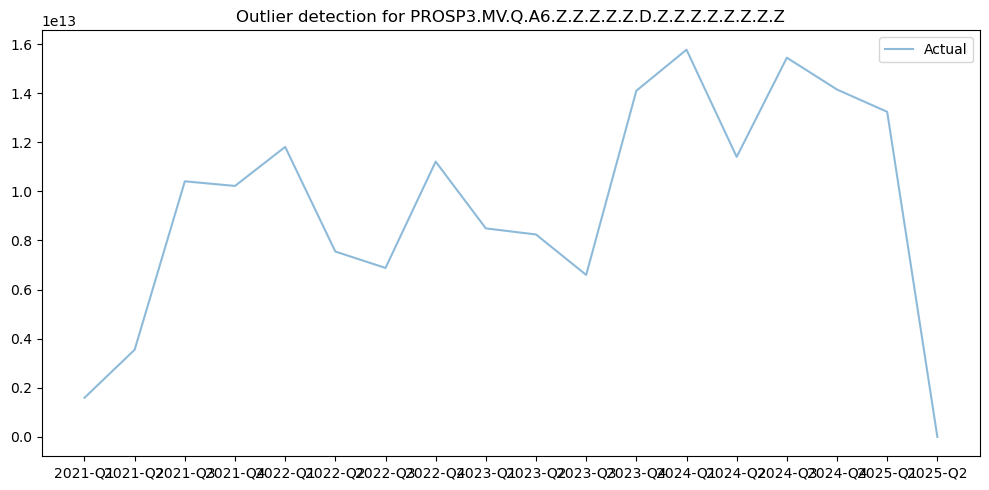

In [ ]:
df_pd = df_joined.toPandas()
key = 'PROSP3.MV.Q.A6.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z'
sub = df_pd[df_pd['KEY'] == key]
sub = sub.sort_values('TIME_PERIOD')

plt.figure(figsize=(10,5))
plt.plot(sub['TIME_PERIOD'], sub['OBS_VALUE'], label='Actual', alpha=0.5)
plt.title(f'Outlier detection for {key}')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def _infer_freq_and_m(index: pd.DatetimeIndex):
    """
    Infer the frequency string and seasonal period m from a datetime index.
    """
    freq = pd.infer_freq(index)
    if freq is None:
        # fallback: check day differences
        diffs = np.diff(index.values.astype('datetime64[D]')).astype(int)
        if np.all(diffs == diffs[0]):
            freq = 'D' if diffs[0] == 1 else 'M' if 28 <= diffs[0] <= 31 else None
        if freq is None:
            raise ValueError(f"Could not infer a consistent freq from index: {index[:5]}")
    # map to seasonal period
    if freq.startswith('Q'):
        m = 4
    elif freq.startswith('M'):
        m = 12
    elif freq.startswith('W'):
        m = 52
    elif freq.startswith('D'):
        m = 7
    else:
        raise ValueError(f"Unsupported frequency: {freq}")
    return freq, m


def fit_arima_and_flag_outliers(
        df: pd.DataFrame,
        key: str,
        key_col: str = 'key',
        date_col: str = 'period',
        value_col: str = 'value'):
    """
    Filter df by key, fit a seasonal ARIMA, and flag outliers beyond 3σ.

    Returns:
      model      - the fitted pmdarima model
      results_df - DataFrame with ['value','pred','resid','outlier'] indexed by date
    """
    sub = df[df[key_col] == key].copy()
    if sub.empty:
        raise ValueError(f"No data found for key={key}")

    # parse and set index
    sub[date_col] = pd.to_datetime(sub[date_col])
    sub = sub.set_index(date_col).sort_index()

    # infer freq & seasonal period, restrict to actual data span
    freq, m = _infer_freq_and_m(sub.index)
    sub = sub.asfreq(freq)

    # fit seasonal ARIMA (auto selects d and D for stationarity)
    model = pm.auto_arima(
        sub[value_col],
        seasonal=True,
        m=m,
        error_action='ignore',
        suppress_warnings=True
    )

    # in-sample predictions (skip warm-up)
    preds = pd.Series(
        model.predict_in_sample(start=m),
        index=sub.index[m:]
    )
    actual = sub[value_col].iloc[m:]
    resid = actual - preds

    # flag points >3σ
    sigma = resid.std()
    outliers = resid.abs() > 3 * sigma

    results_df = pd.DataFrame({
        'value': actual,
        'pred': preds,
        'resid': resid,
        'outlier': outliers
    })
    return model, results_df


def plot_results(results_df: pd.DataFrame):
    """
    Plot actual vs predicted and highlight outliers.
    """
    plt.figure()
    plt.plot(results_df.index, results_df['value'], label='Actual')
    plt.plot(results_df.index, results_df['pred'], label='Predicted')
    out = results_df[results_df['outlier']]
    plt.scatter(out.index, out['value'], label='Outliers')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('ARIMA Fit and Outliers')
    plt.show()


def plot_qq(results_df: pd.DataFrame):
    """
    Display a QQ-plot of the residuals against a normal distribution.
    """
    resid = results_df['resid'].dropna()
    osm, osr = stats.probplot(resid, dist='norm', fit=False)

    plt.figure()
    plt.scatter(osm, osr, s=20)
    mn = min(osm.min(), osr.min())
    mx = max(osm.max(), osr.max())
    plt.plot([mn, mx], [mn, mx], linestyle='--')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.title('QQ Plot of Residuals')
    plt.show()


In [26]:
monthly = pd.read_csv('Prosp3_monthly_series.csv')

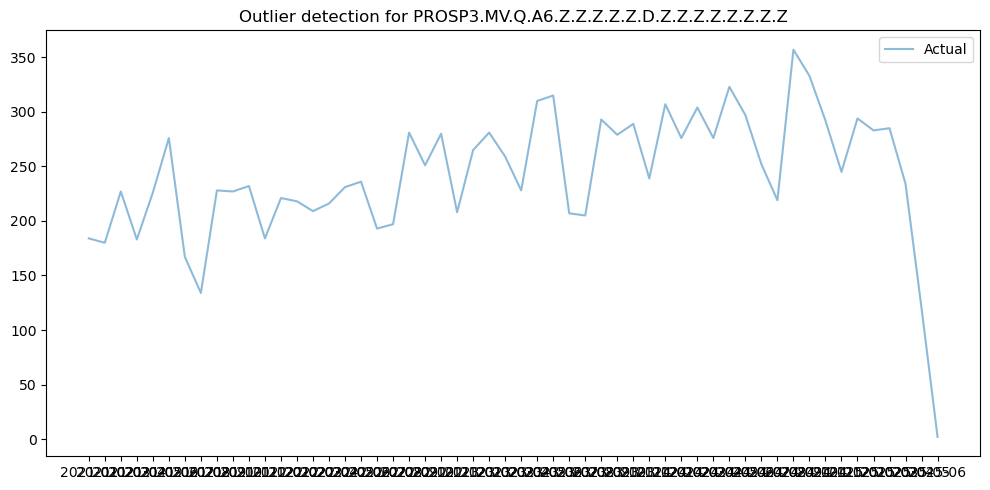

In [27]:
monthly = monthly[monthly['KEY']== 'PROSP3.NUM_ISSUER.M.A6.Z.Z.Z.Z.Z.D.A6.Z.Z.Z.Z.Z.Z.Z']
monthly= monthly.sort_values('TIME_PERIOD')
plt.figure(figsize=(10,5))
plt.plot(monthly['TIME_PERIOD'], monthly['OBS_VALUE'], label='Actual', alpha=0.5)
plt.title(f'Outlier detection for {key}')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
model, flagged = fit_arima_and_flag_outliers(monthly, key='PROSP3.NUM_ISSUER.M.A6.Z.Z.Z.Z.Z.D.A6.Z.Z.Z.Z.Z.Z.Z',
                                           key_col='KEY', date_col='TIME_PERIOD', value_col='OBS_VALUE')
print(flagged[flagged['outlier']])

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/

             value        pred       resid  outlier
TIME_PERIOD                                        
2025-05-01     120  284.306883 -164.306883     True


In [29]:
flagged

,value,pred,resid,outlier
TIME_PERIOD,,,,
2022-01-01,221,201.631384,19.368616,False
2022-02-01,218,214.086794,3.913206,False
2022-03-01,209,262.008059,-53.008059,False
2022-04-01,216,166.417235,49.582765,False
2022-05-01,231,256.401735,-25.401735,False
2022-06-01,236,280.606323,-44.606323,False
2022-07-01,193,130.149412,62.850588,False
2022-08-01,197,157.952882,39.047118,False
2022-09-01,281,286.039676,-5.039676,False


In [30]:
def plot_results(results_df: pd.DataFrame):
    """
    Plot actual vs predicted values and highlight outliers.
    """
    plt.figure()
    plt.plot(results_df.index, results_df['value'], label='Actual')
    plt.plot(results_df.index, results_df['pred'], label='Predicted')
    out = results_df[results_df['outlier']]
    plt.scatter(out.index, out['value'], label='Outliers')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('ARIMA Fit and Outliers')
    plt.show()

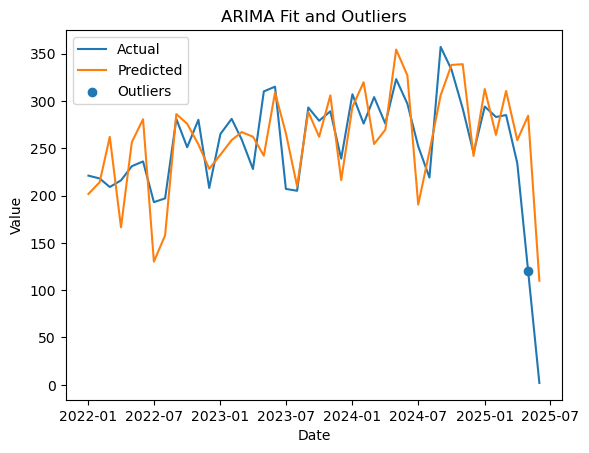

In [31]:
plot_results(flagged)

In [ ]:
def plot_arima_esma(
    results_df,
    date_col='TIME_PERIOD',
    obs_col='value',
    pred_col='pred',
    outlier_col='outlier',
    title =' '
):
    """
    ESMA‐style interactive chart:
      • solid blue line = actuals (excluding outliers)
      • dashed blue line = ARIMA forecast
      • orange dots = outliers
      plus light-grey horizontal grid lines
    """
    df = results_df.copy()
    if date_col not in df.columns:
        df.index.name = date_col
        df = df.reset_index()

    df[outlier_col] = df[outlier_col].astype(bool)
    normal = df[~df[outlier_col]]
    out    = df[df[outlier_col]]

    eplot = esmaplotly()
    fig = go.Figure()

    # 1) actuals line (ESMA blue)
    fig.add_trace(go.Scatter(
        x=normal[date_col],
        y=normal[obs_col],
        mode='lines',
        name='Actual',
        line=dict(color='#007EFF', width=2),
        legendgroup='act'
    ))

    # 2) forecast line (dashed ESMA blue)
    fig.add_trace(go.Scatter(
        x=df[date_col],
        y=df[pred_col],
        mode='lines',
        name='Forecast',
        line=dict(color='#7BD200', dash='dash', width=2),
        legendgroup='fc'
    ))

    # 3) outlier markers (ESMA orange)
    fig.add_trace(go.Scatter(
        x=out[date_col],
        y=out[obs_col],
        mode='markers',
        name='Outlier',
        marker=dict(color='#DB5700', size=8),
        legendgroup='pts'
    ))

    # apply ESMA layout & annotation
    fig = eplot.update_chart_trv(
        fig,
        annotation_text="Orange dots represent the flagged outliers; dashed line is the ARIMA forecast. <br> Note: The monthly ARIMA needs 12 periods to learn the dynamics of the timeseries."
    )
    fig.update_layout(title=title)

    # --- NEW: turn on horizontal grid lines on the y-axis ---
    fig.update_yaxes(
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)',  # light grey
        gridwidth=1
    )

    # export high-res if you like
    fig.write_image("chart_highres.png", width=1600, height=900, scale=2)
    fig.write_image("chart1.svg")

    fig.show()

# call exactly as before
plot_arima_esma(
    flagged,
    date_col='TIME_PERIOD',
    obs_col='value',
    pred_col='pred',
    outlier_col='outlier'
)

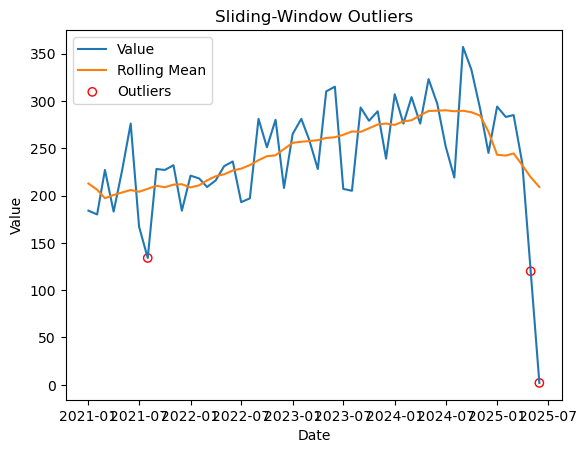

In [33]:
def flag_outliers_sliding_window(
        df: pd.DataFrame,
        key: str,
        key_col: str = 'KEY',
        date_col: str = 'TIME_PERIOD',
        value_col: str = 'OBS_VALUE',
        window: int = 12,
        threshold: float = 4.0,
        robust: bool = False):
    """
    Rolling-window outlier detection.
    If robust=False uses rolling std, else rolling MAD.
    Returns DataFrame with value, rolling_mean, rolling_scale, resid, outlier.
    """
    sub = df[df[key_col] == key].copy()
    if sub.empty:
        raise ValueError(f"No data for key={key}")
    sub[date_col] = pd.to_datetime(sub[date_col])
    sub = sub.set_index(date_col).sort_index()
    series = sub[value_col].astype(float).asfreq(pd.infer_freq(sub.index))

    # rolling mean
    roll_mean = series.rolling(window=window, min_periods=1, center=True).mean()
    if robust:
        # rolling MAD
        roll_scale = series.rolling(window=window, min_periods=1, center=True)
        roll_scale = roll_scale.apply(lambda x: np.median(np.abs(x - np.median(x))), raw=False)
    else:
        roll_scale = series.rolling(window=window, min_periods=1, center=True).std()

    resid = series - roll_mean
    outliers = resid.abs() > threshold * roll_scale

    results_df = pd.DataFrame({
        'value': series,
        'rolling_mean': roll_mean,
        'rolling_scale': roll_scale,
        'resid': resid,
        'outlier': outliers
    })
    return results_df


def plot_sliding_window(results_df: pd.DataFrame):
    """
    Plot sliding-window stats: value, rolling_mean, and flagged outliers.
    """
    plt.figure()
    plt.plot(results_df.index, results_df['value'], label='Value')
    plt.plot(results_df.index, results_df['rolling_mean'], label='Rolling Mean')
    out = results_df[results_df['outlier']]
    plt.scatter(out.index, out['value'], facecolors='none', edgecolors='red', label='Outliers')
    plt.legend()
    plt.xlabel('Date'); plt.ylabel('Value'); plt.title('Sliding-Window Outliers')
    plt.show()

# Examples:

flag_df = flag_outliers_sliding_window(monthly, key='PROSP3.NUM_ISSUER.M.A6.Z.Z.Z.Z.Z.D.A6.Z.Z.Z.Z.Z.Z.Z', window=12, threshold=3, robust=True)
plot_sliding_window(flag_df)


In [35]:
def plot_sliding_window_esma_plotly(
        flagged: pd.DataFrame,
        date_col: str = 'TIME_PERIOD',
        value_col: str = 'value',
        rolling_mean_col: str = 'rolling_mean',
        outlier_col: str = 'outlier'):
    # 1) Bring index into a column
    df = flagged.reset_index()
    df[date_col] = pd.to_datetime(df[date_col])

    # 2) Single x-axis, y-series, mask
    x = df[date_col]
    y = df[value_col]
    rm = df[rolling_mean_col]
    mask = df[outlier_col].astype(bool)

    eplot = esmaplotly()
    fig = go.Figure()

    # A) Plot ALL actuals (blue solid) – include outliers in the line
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='lines',
        name='Value',
        line=dict(color='#007EFF', width=4),
        legendgroup='val'
    ))

    # B) Rolling mean (green dashed)
    fig.add_trace(go.Scatter(
        x=x,
        y=rm,
        mode='lines',
        name='Rolling Mean',
        line=dict(color='#7BD200', dash='dash', width=4),
        legendgroup='mean'
    ))

    # C) Outlier markers (orange open circles)
    fig.add_trace(go.Scatter(
        x=x[mask],
        y=y[mask],
        mode='markers',
        name='Outliers',
        marker=dict(color='#DB5700', size=14, symbol='circle'),
        legendgroup='out'
    ))

    # Horizontal gridlines on y-axis
    fig.update_yaxes(
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)',
        gridwidth=1
    )
    fig.update_xaxes(showgrid=False)

    # Transparent background & layout
    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        font=dict(size=14),
        legend=dict(font=dict(size=14)),
        margin=dict(l=60, r=40, t=60),  # extra bottom for annotation
        width=1000, height=600
    )

    # ESMA footer annotation — manually added so it exports
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0, y=-0.15,
        showarrow=False,
        text="Note: rolling-window outliers flagged at ±4σ around the dashed trend.",
        font=dict(size=16),
        align="left"
    )

    # Save & show
    fig.write_image('sliding_window_esma.png', width=1000, height=600, scale=2)
    fig.show()
    return fig

# Call it without any other changes:
plot_sliding_window_esma_plotly(
    flag_df,
    date_col='TIME_PERIOD',
    value_col='value',
    rolling_mean_col='rolling_mean',
    outlier_col='outlier'
)

## 3. Encoder

### Make the encoder one make more sense

In [36]:
def fit_autoencoder_and_flag_outliers(
        df: pd.DataFrame,
        key: str,
        key_col: str = 'KEY',
        date_col: str = 'TIME_PERIOD',
        value_col: str = 'OBS_VALUE',
        window_size: int = 5,
        latent_dim: int = 2,
        epochs: int = 50,
        batch_size: int = 16,
        threshold: float = 2.0,
        threshold_method: str = 'std'):
    """
    Train a simple autoencoder on sliding windows and flag outliers by reconstruction error.

    Parameters:
      df               - DataFrame with key/date/value columns
      key              - filter value in key_col
      window_size      - number of time steps per window
      latent_dim       - dimensionality of encoded representation
      epochs           - training epochs
      batch_size       - training batch size
      threshold        - multiplier (for 'std') or quantile (for 'quantile')
      threshold_method - 'std' uses mean+threshold*std; 'quantile' uses (1-threshold) quantile

    Returns:
      model      - trained keras autoencoder
      results_df - DataFrame indexed by date (window end) with columns:
                   ['value', 'recon_error', 'outlier']
    """
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.optimizers import Adam

    # filter and prepare
    sub = df[df[key_col] == key].copy()
    if sub.empty:
        raise ValueError(f"No data for key={key}")
    sub[date_col] = pd.to_datetime(sub[date_col])
    sub = sub.set_index(date_col).sort_index()
    series = sub[value_col].astype(float).asfreq(pd.infer_freq(sub.index))
    values = series.values.reshape(-1, 1)

    # scale to [0,1]
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    # build sliding windows
    X = []
    for i in range(len(scaled) - window_size + 1):
        X.append(scaled[i:i + window_size].flatten())
    X = np.array(X)

    # train/test split: use all for training
    X_train = X

    # autoencoder architecture
    input_dim = window_size
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(latent_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoenc = Model(inputs=input_layer, outputs=decoded)
    autoenc.compile(optimizer=Adam(), loss='mse')

    # train
    autoenc.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)

    # reconstruction
    X_pred = autoenc.predict(X)
    # compute mse per window
    mse = np.mean(np.power(X - X_pred, 2), axis=1)

    # determine threshold
    if threshold_method == 'std':
        mean_mse = mse.mean()
        std_mse = mse.std()
        err_thresh = mean_mse + threshold * std_mse
    elif threshold_method == 'quantile':
        err_thresh = np.quantile(mse, 1 - threshold)
    else:
        raise ValueError("threshold_method must be 'std' or 'quantile'")

    # map errors & outliers to dates (window end)
    dates = series.index[window_size - 1:]
    recon_error = pd.Series(mse, index=dates)
    outliers = recon_error > err_thresh

    results_df = pd.DataFrame({
        'value': series[window_size - 1:],
        'recon_error': recon_error,
        'outlier': outliers
    })
    return autoenc, results_df


def plot_autoencoder_outliers(results_df: pd.DataFrame):
    """
    Plot time series with autoencoder outliers highlighted.
    """
    plt.figure()
    plt.plot(results_df.index, results_df['value'], label='Value')
    out = results_df[results_df['outlier']]
    plt.scatter(out.index, out['value'], s=80,
                facecolors='none', edgecolors='red', label='Outliers')
    plt.legend()
    plt.xlabel('Date'); plt.ylabel('Value'); plt.title('Autoencoder Anomaly Detection')
    plt.show()

In [37]:
au, e = fit_autoencoder_and_flag_outliers(monthly, key='PROSP3.NUM_ISSUER.M.A6.Z.Z.Z.Z.Z.D.A6.Z.Z.Z.Z.Z.Z.Z')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [38]:
e

,value,recon_error,outlier
TIME_PERIOD,,,
2021-05-01,226.0,0.005255,False
2021-06-01,276.0,0.010932,False
2021-07-01,167.0,0.008919,False
2021-08-01,134.0,0.023023,False
2021-09-01,228.0,0.027558,False
2021-10-01,227.0,0.024968,False
2021-11-01,232.0,0.009008,False
2021-12-01,184.0,0.004957,False
2022-01-01,221.0,0.009319,False


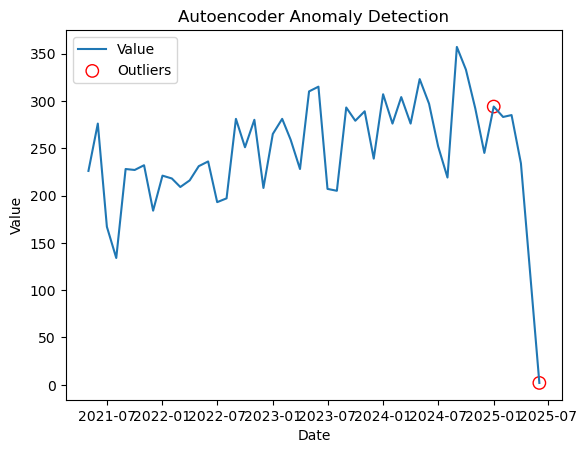

25/06/17 01:08:52 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 972822 ms exceeds timeout 120000 ms
25/06/17 01:08:52 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/17 01:08:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [ ]:
plot_autoencoder_outliers(e)